In [1]:
from preprocess import load_intel_data
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
%load_ext autoreload
%autoreload 2

Found 14034 files belonging to 6 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-24 13:19:09.866774: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


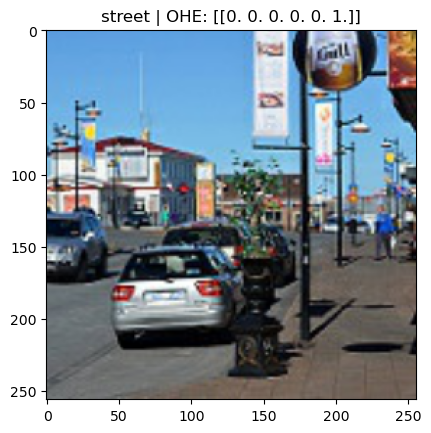

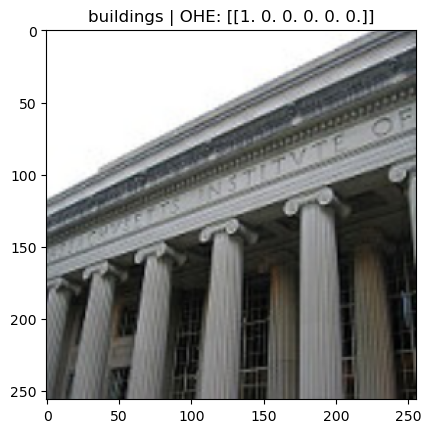

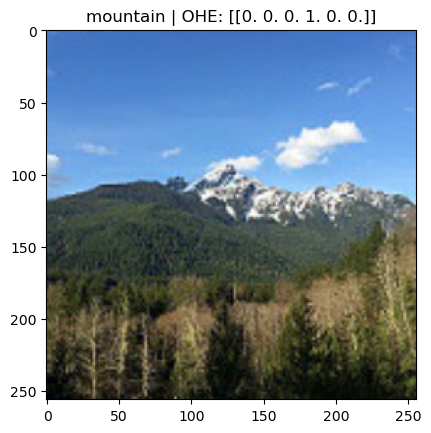

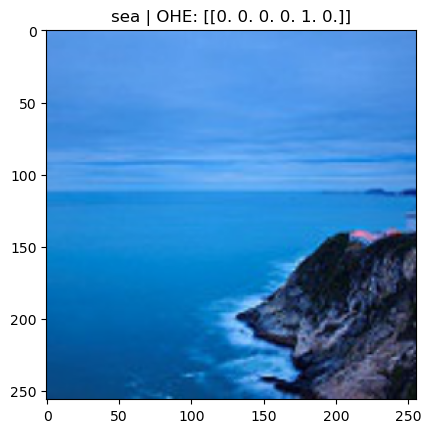

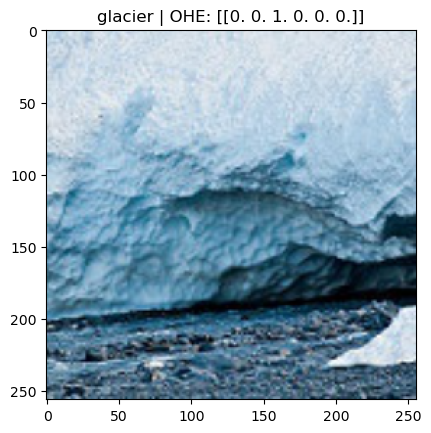

In [3]:
translation_dict = {0:'buildings', 1:'forest', 2:'glacier',3:'mountain',4:'sea',5:'street'}
image_dataset = load_intel_data('data/intel_images/seg_train', 1)

# Visualize the first 5 images in the dataset with their class names
for image, label in image_dataset.take(5):
    plt.imshow(image[0].numpy())
    class_index = tf.argmax(label[0]).numpy()
    class_name = translation_dict[class_index]
    plt.title(class_name + " | OHE: " + str(label.numpy()))
    plt.show()

In [4]:
checkpoint_path = "conv_model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [30]:
# #NO NEED TO RUN THIS CODE ANYMORE, ALREADY TRAINED TO DECENT ACCURACY

# from convolutional_encoder import ConvolutionalEncoder

# model = ConvolutionalEncoder()

# batch_size = 32
# train_dataset = load_intel_data('data/intel_images/seg_train', batch_size)
# test_dataset = load_intel_data('data/intel_images/seg_test', batch_size)
# epochs = 5
# model = ConvolutionalEncoder()
# lr = 1e-3

# model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#     metrics=['accuracy']
# )

# model.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=test_dataset,
#     callbacks=[cp_callback]
# )

In [290]:
from convolutional_encoder import ConvolutionalEncoder
new_model = ConvolutionalEncoder()
### NOTE: In order to run this, you might need to download the checkpoints from the actual Github.
### This may be the case if you are getting a "bad magic number" type error.

new_model.load_weights('conv_model_checkpoints/cp.ckpt')

In [6]:
batch_size = 32
test_dataset = load_intel_data('data/intel_images/seg_test', batch_size)
epochs = 10
lr = 1e-3

new_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy']
)

new_model.evaluate(test_dataset)

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 64s 678ms/step - loss: 0.9034 - accuracy: 0.7723


[0.9034301042556763, 0.7723333239555359]

**Summary:** The model trained over 5 epochs to a loss of 0.9034 and an accuracy of ~77%. It overfit a bit as well.

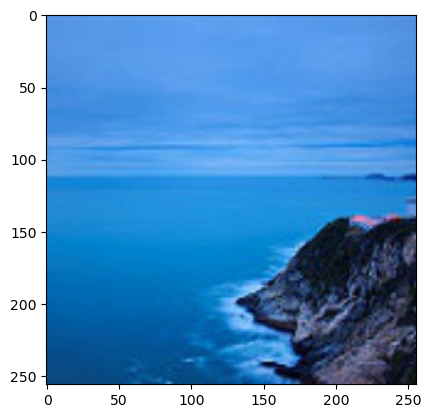

Actual: sea
1/1 [==============================] - 0s 110ms/step
Predicted: sea


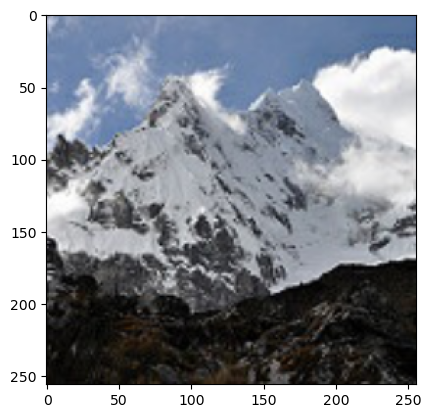

Actual: mountain
1/1 [==============================] - 0s 47ms/step
Predicted: mountain


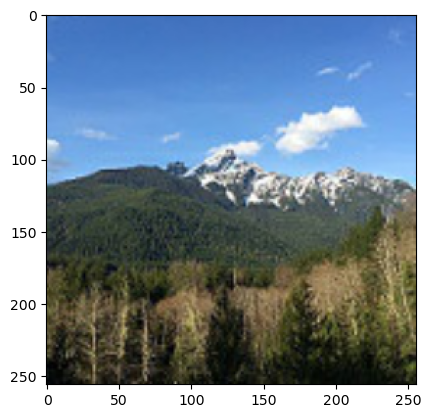

Actual: mountain
1/1 [==============================] - 0s 43ms/step
Predicted: mountain


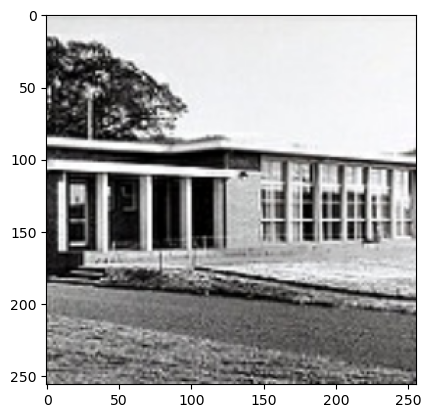

Actual: buildings
1/1 [==============================] - 0s 41ms/step
Predicted: buildings


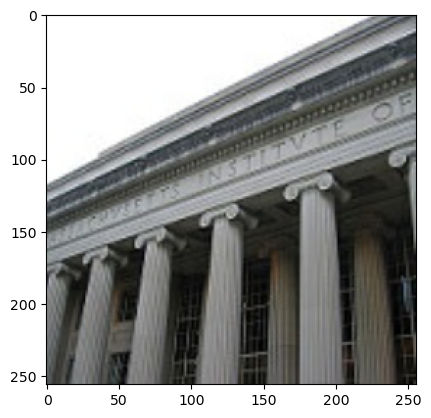

Actual: buildings
1/1 [==============================] - 0s 44ms/step
Predicted: buildings


In [7]:
for image, label in image_dataset.take(5):
    plt.imshow(image[0].numpy())
    class_index = tf.argmax(label[0]).numpy()
    class_name = translation_dict[class_index]
    plt.show()
    print("Actual: " + class_name)
    print("Predicted: " + translation_dict[tf.argmax(new_model.predict(image), axis=1).numpy()[0]])

In [123]:
conv_layers = new_model.layers[0].layers
content_layer = conv_layers[7]
style_layer = conv_layers[6]

content_encoder = tf.keras.models.Model(inputs=new_model.layers[0].input, outputs=content_layer.output)
style_encoder = tf.keras.models.Model(inputs=new_model.layers[0].input, outputs=style_layer.output)

8
9


In [124]:
from decoder import NeuralStyleTransferModel

content_encoder.trainable = False
style_encoder.trainable = False
nst = NeuralStyleTransferModel(content_encoder, style_encoder)

In [221]:
from preprocess import load_tfrec_data

monet_dataset = load_tfrec_data('data/monet_tfrec', batch_size)
train_dataset = load_tfrec_data('data/photo_tfrec', batch_size)

combined = tf.data.Dataset.zip((train_dataset, monet_dataset))

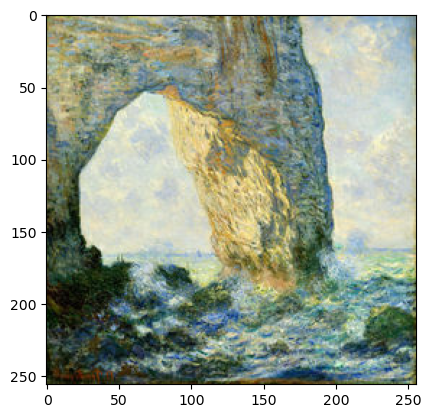

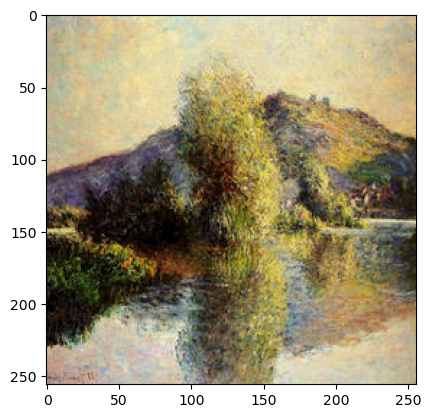

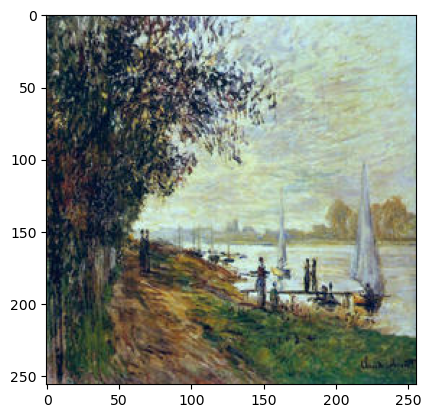

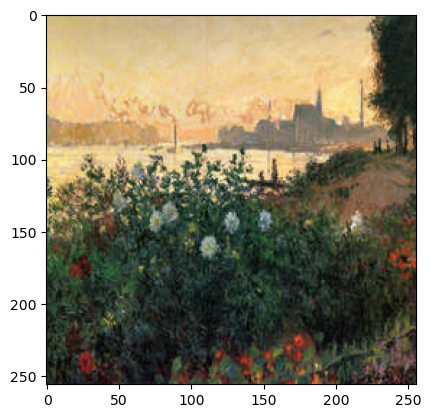

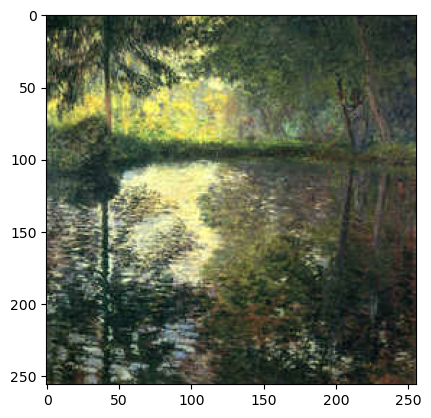

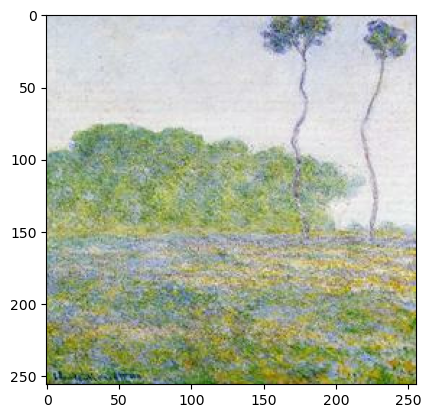

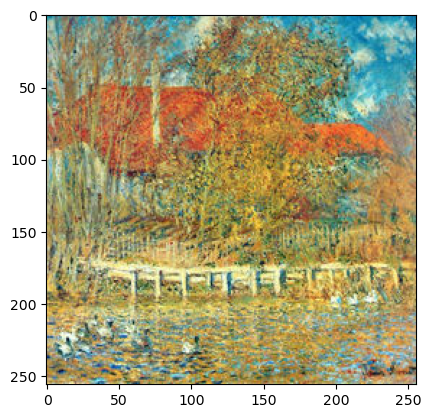

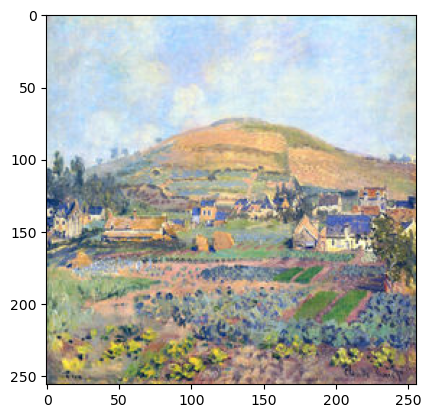

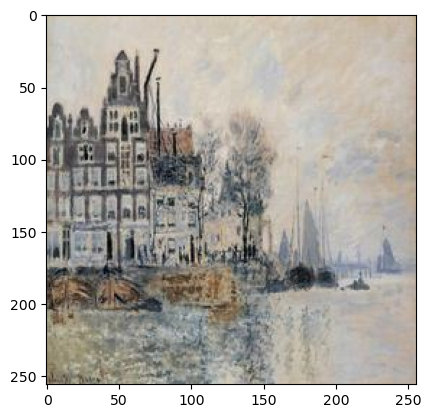

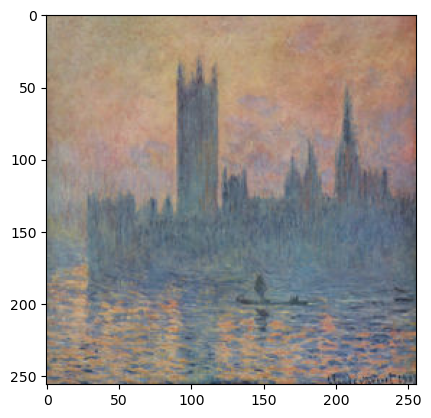

In [292]:
for image in monet_dataset.take(30):
    plt.imshow(image[0])
    plt.show()

In [204]:
next(iter(combined.take(1)))[0].shape

TensorShape([32, 256, 256, 3])

In [276]:
c_sample = next(iter(train_dataset.take(1)))
s_sample = next(iter(monet_dataset.take(1)))[0]

In [277]:
import numpy as np
s_sample_tile = np.tile(s_sample, (32, 1, 1, 1))
s_sample_tile.shape

(32, 256, 256, 3)

In [278]:
train_dataset_mapped = tf.data.Dataset.map(train_dataset, lambda x: (x, s_sample_tile))
#train_dataset_mapped = tf.data.Dataset.zip((train_dataset, train_dataset))
c2_sample = next(iter(train_dataset_mapped.take(1)))

In [248]:
import numpy as np


In [280]:
c2_sample[0].shape

TensorShape([32, 256, 256, 3])

In [289]:
from decoder import loss_fn
import sys
batch_size = 32

epochs = 5
lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


nst.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
)

nst.fit(
    train_dataset_mapped
)


# def train_step(model, input):
#     zipped = tf.convert_to_tensor([input, s_sample])
#     with tf.GradientTape() as tape:
#         pred = model(zipped)
#         loss = loss_fn(pred, zipped, style_encoder)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return loss

# for epoch in range(epochs):
#     print(f"Epoch {epoch} starting")
#     epoch_loss = 0
#     c = 0
#     for image in train_dataset:
#         c += 1
#         epoch_loss += train_step(nst, image)
#         sys.stdout.write("\rAverage loss: " + str(epoch_loss / c))
#         sys.stdout.flush()
#     print(f"Epoch loss: {epoch_loss}")




      4/Unknown - 87s 22s/step - loss: 3.7006e-04 - mae: 1.6191

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


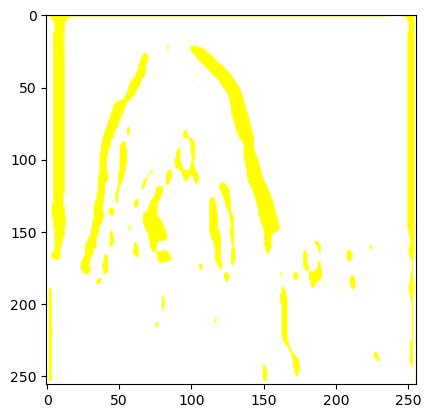

In [242]:

plt.imshow(nst(c_sample, s_sample)[0])
plt.show()

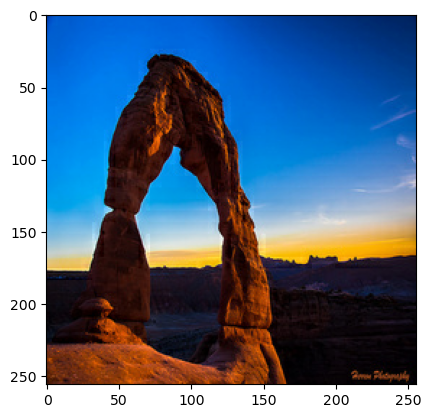

In [245]:

plt.imshow(c_sample[0])
plt.show()